# Описание проекта

Интернет-магазин «Стримчик» продаёт компьютерные игры по всему миру. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation).

Имеются данные до 2016 года в наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

**Цель исследования**

Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании на 2017 год.

**Гипотезы исследования**

1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
2. Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats as st
import math
import seaborn as sns

### Откроем файл с данными и изучаем общую информацию

In [2]:
try:
    data = pd.read_csv ('/datasets/games.csv')
except:
    data = pd.read_csv ('https://raw.githubusercontent.com/Cellport/Projects/main/%D0%98%D1%81%D1%81%D0%BB%D0%B5%D0%B4%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5%20%D0%B7%D0%B0%D0%BA%D0%BE%D0%BD%D0%BE%D0%BC%D0%B5%D1%80%D0%BD%D0%BE%D1%81%D1%82%D0%B5%D0%B9%20%D1%83%D1%81%D0%BF%D0%B5%D1%88%D0%BD%D0%BE%D1%81%D1%82%D0%B8%20%D0%B8%D0%B3%D1%80/games.csv')

In [3]:
data.head(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Проверили датафрейм на наличие пропусков и типы данных в столбцах, а также просмотрели как нужно изменить названия столбцов. Это нам понадобится для предобработки данных и корректного анализа. Вывели несколько строк датафрейма для проверки того что данные загружены верно и увидели также, что столбцы нужно привести к строчному виду и *snakecase*. Некоторые столбцы **year_of_release** и **user_score** требуют изменения типов данных, пропущенные значения в других столбцах также заполним на этапе предобработки.

### Подготовим данные для исследования

#### Заменяем названия столбцов (приводим к нижнему регистру)

In [5]:
data.columns = data.columns.str.lower()

#### Приводим данные к нужному типу

Меняем типы данных в столбцах:

- **year_of_release** на int, так как год - целое число- **user_score** на float64, так как он содержит числовые данные

In [6]:
data['year_of_release'] = data['year_of_release'].astype('Int64')


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(5), object(5)
memory usage: 1.4+ MB


#### Проведём обработку пропусков

Разберёмся подробнее в каких столбцах датафрейма есть пропуски и в каком количестве.

In [8]:
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
name,0.000000
platform,0.000000
year_of_release,2.000000
genre,0.000000
na_sales,0.000000
eu_sales,0.000000
jp_sales,0.000000
other_sales,0.000000
critic_score,51.000000
user_score,40.000000


Пропуски в данных могут быть связаны с необязательностью проставления пользовательской оценки, оценки критиков и рейтинга. Можно без колебаний удалить строки с пропусками в столбце **year_of_release**, так как их всего 2%, такое число вряд-ли повлияет на корректность исследования. В столбце **name** количество пропусков несущественно, можно удалить. Более важны и существенны пропуски в столбцах **critic_score**, **user_score** и **rating**, в них содержатся числовые данные, которые важны для исследования. Отсутствующие значения в столбце **rating** заполним заглушкой, означающей отсутствие рейтинга. В столбцах **critic_score**, **user_score** пропуски заменим на число *-1*, так мы выделим отдельную категорию отсутствующих оценок. Аббревиатуру *tbd*, что означает 'Подлежит уточнению', заменим её на *-2*. Одинаковое количество пропусков в **user_score** и **rating** можно объяснить тем, что рейтинг выставляется на основе оценки пользователей.

In [9]:
data.dropna(subset=['year_of_release'], inplace=True)

In [10]:
data.dropna(subset=['name'], inplace=True)

Более существенны пропуски в столбцах **critic_score**, **user_score** и  **rating**, так как их там от 40% до 51%. Отсутствующие значения в столбце **rating** заполним заглушкой, означающей отсутствие рейтинга. В столбцах **critic_score**, user_score пропуски заменим на число -1, так мы выделим отдельную категорию отсутствующих оценок. Аббревиатуру *tbd*, что означает 'Подлежит уточнению', заменим её на -2.

In [11]:
data['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 41., 36., 31., 27., 35., 26., 19., 28., 23.,
       24., 21., 17., 13.])

In [12]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [13]:
data['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [14]:
data.loc[data['rating'].isna(), 'rating'] = 'Отсутствует'
data['rating'].unique()

array(['E', 'Отсутствует', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'],
      dtype=object)

In [15]:
data.loc[data['user_score'].isna(), 'user_score'] = -1

In [16]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = -2

In [17]:
data['user_score'].unique()

array(['8', -1, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', -2, '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [18]:
#поменяем тип столбца на числовой
data['user_score'] = pd.to_numeric(data['user_score'])

In [19]:
data.loc[data['critic_score'].isna(), 'critic_score'] = -1
data['critic_score'].unique()

array([76., -1., 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 41., 36., 31., 27., 35., 26., 19., 28., 23.,
       24., 21., 17., 13.])

In [20]:
data['user_score'] = data['user_score'].astype('float64')

#### Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец

In [21]:
data['total_sales'] = data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

Проверим датафрейм на наличие явных и неявных дубликатов

In [22]:
#проверим явные дубликаты
data.duplicated().sum()

0

In [23]:
#проверим и удалим неявные дубликаты в столбцах с названием игры и платформы
data.drop_duplicates(subset=['name', 'platform'])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1.0,-1.0,Отсутствует,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1.0,-1.0,Отсутствует,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,-1.0,-1.0,Отсутствует,0.01
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,-1.0,-1.0,Отсутствует,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,-1.0,-1.0,Отсутствует,0.01
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,-1.0,-1.0,Отсутствует,0.01


На данном этапе исследования мы нашли пропуски в столбцах, выявили из природу и обработали, согласно логике исследования с той целью, чтобы не пропали значимые данные. Также была проведена проверка на дубликаты для того, чтобы исключить их влияние на результаты исследования.

### Проведём исследовательский анализ данных

#### Посмотрим сколько игр выпускалось в разные годы. Определим важны ли данные за все периоды?

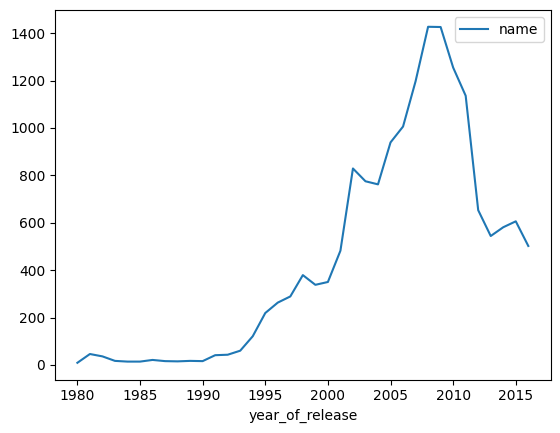

In [24]:
releases = data.pivot_table(index='year_of_release', values='name', aggfunc='count')
releases.plot();

В наличии имеется статистика об играх, выпускаемых с **1980** года, до 1994 года счёт релизов шёл на десятки, вероятно эти данные менее важны, так как не будут отражать общую тенденцию. Восходящий тренд, соответствующий нормальному распределению, отмечается как раз с 1994 года.

#### Определим как менялись продажи по платформам

Выберем платформы с наиюольшими суммарными продажами и построим распределение по годам. Выявим за какой характерный срок появляются и исчезают старые платформы.

In [25]:
platform_grouped = data.pivot_table(index=['platform'], values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False)

In [26]:
data.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by ='total_sales', ascending = False)

,total_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


In [27]:
top = platform_grouped.sort_values(by='total_sales').iloc[-5:].index
top

Index(['DS', 'Wii', 'PS3', 'X360', 'PS2'], dtype='object', name='platform')

In [28]:
platform_top = data[data['platform'].isin(top)]
platform_top

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91
...,...,...,...,...,...,...,...,...,...,...,...,...
16700,Mezase!! Tsuri Master DS,DS,2009,Sports,0.00,0.00,0.01,0.00,-1.0,-1.0,Отсутствует,0.01
16704,Plushees,DS,2008,Simulation,0.01,0.00,0.00,0.00,-1.0,-2.0,E,0.01
16709,SCORE International Baja 1000: The Official Game,PS2,2008,Racing,0.00,0.00,0.00,0.00,-1.0,-1.0,Отсутствует,0.00
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,-1.0,-1.0,Отсутствует,0.01


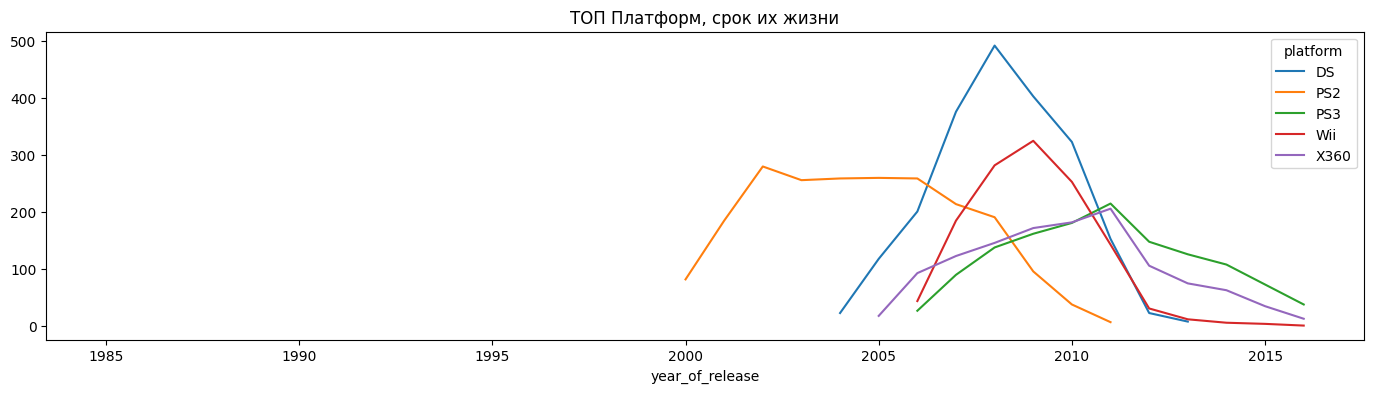

In [29]:
platform_top.groupby(['platform', 'year_of_release'])['total_sales'].count().unstack('platform').plot(figsize=(17, 4), title='ТОП Платформ, срок их жизни');

Очевидно, что в ТОП самых популярных игровых платформ за весь исследуемый период входят: **PS2, X360, PS3, Wii, DS**, развитие которых происходило с начала нулевых годов. Срок "жизни" платформ из ТОПа ориентировочно около 10 лет.

#### Определим актуальный период для построения прогноза на 2017 год и определим лидеров продаж

In [30]:
actual_period = data.query('year_of_release > 2013')
actual_period

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,-1.0,-1.0,Отсутствует,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,-1.0,-1.0,Отсутствует,11.68
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,-1.0,-1.0,Отсутствует,7.98
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,-1.0,-1.0,Отсутствует,0.01
16707,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,-1.0,-1.0,Отсутствует,0.01
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,-1.0,-1.0,Отсутствует,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,-1.0,-1.0,Отсутствует,0.01


In [31]:
sales_top = actual_period.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales').iloc[-5:].index
sales_top

Index(['X360', 'PS3', '3DS', 'XOne', 'PS4'], dtype='object', name='platform')

Лучшие показатели продаж показывают игры для следующих платформ: **XOne, 3DS, PS4, X360, PS3**

#### Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам.

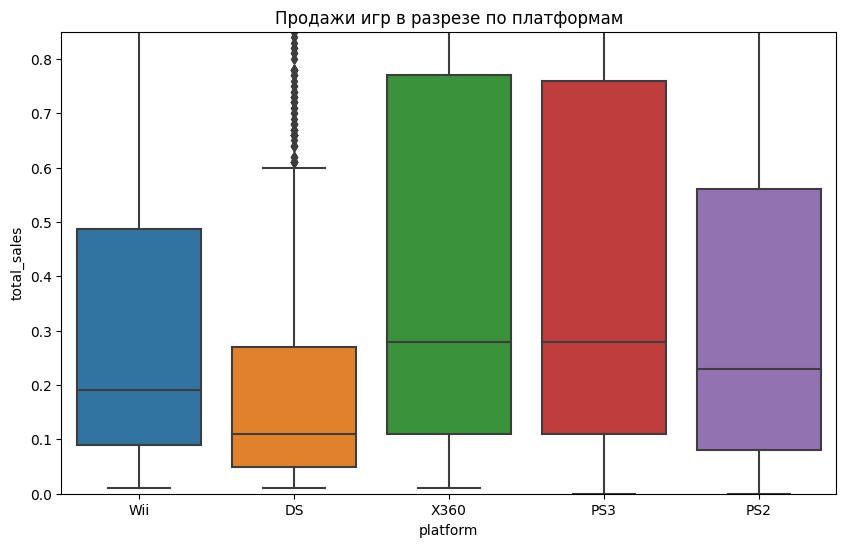

In [32]:
plt.figure(figsize=(10, 6));
sns.boxplot(x='platform', y='total_sales', data=platform_top);
plt.ylim(0, 0.85);

plt.title('Продажи игр в разрезе по платформам');

Полученный график показывает что наиболее высоки медианы продаж у платформ **X360** и **PS3**. При этом они же имеют явное смещение в сторону более высокой цены, относительно медианы.

#### Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами.


В качестве примера возьмем информацию о платформе PS4, так как она имеет большое количество продаж и популярность

In [33]:
ps4 = actual_period[(actual_period['platform'] == 'PS4') \
                    & (actual_period['critic_score']>0) \
                    & (actual_period['user_score']>0)].copy()

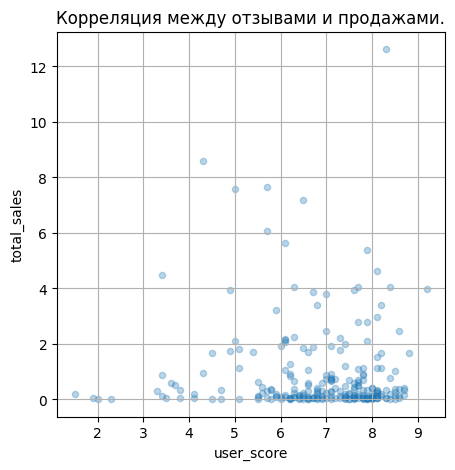

In [34]:
ps4.plot(x='user_score', y='total_sales', kind='scatter', alpha=0.3, figsize=(5,5), grid=True, title='Корреляция между отзывами и продажами.')
plt.show()

Замена пропусков на *-1* и *tbd* на -2 позволила нам увидеть их на графиках и не учитывать в оценке корреляции.

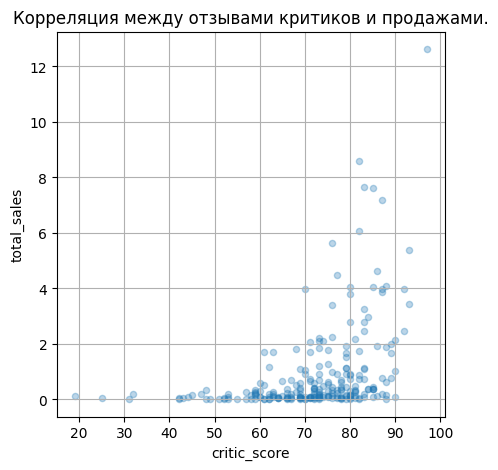

In [35]:
ps4.plot(x='critic_score', y='total_sales', kind='scatter', alpha=0.3, figsize=(5,5), grid=True, title='Корреляция между отзывами критиков и продажами.')
plt.show()

In [36]:
ps4.corr()

C:\Users\Alim\AppData\Local\Temp\ipykernel_8652\839410094.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  ps4.corr()


,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales
year_of_release,1.000000,-0.230985,-0.183494,-0.093172,-0.221852,-0.043417,0.028938,-0.216492
na_sales,-0.230985,1.000000,0.712972,0.566980,0.915730,0.410773,-0.018847,0.892578
eu_sales,-0.183494,0.712972,1.000000,0.541119,0.934511,0.339526,-0.067377,0.951783
jp_sales,-0.093172,0.566980,0.541119,1.000000,0.598046,0.378852,0.182245,0.618891
other_sales,-0.221852,0.915730,0.934511,0.598046,1.000000,0.403824,-0.047267,0.998054
critic_score,-0.043417,0.410773,0.339526,0.378852,0.403824,1.000000,0.546434,0.401903
user_score,0.028938,-0.018847,-0.067377,0.182245,-0.047267,0.546434,1.000000,-0.043186
total_sales,-0.216492,0.892578,0.951783,0.618891,0.998054,0.401903,-0.043186,1.000000


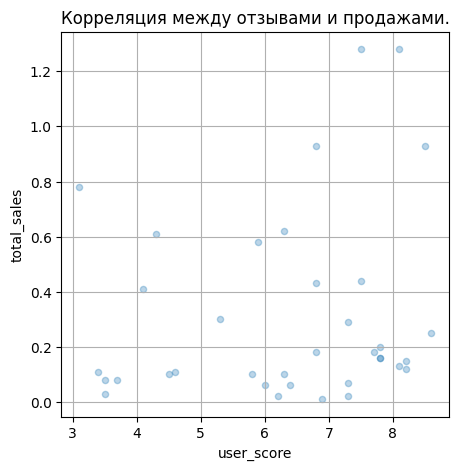

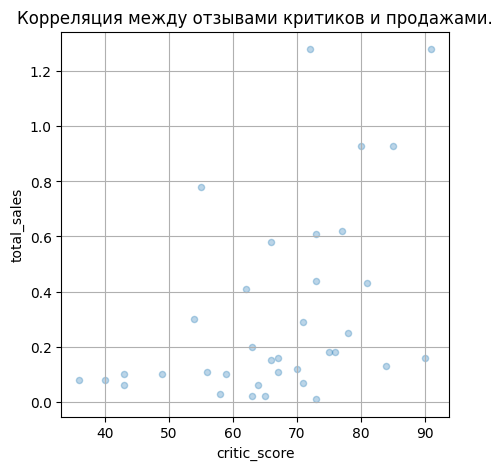

C:\Users\Alim\AppData\Local\Temp\ipykernel_8652\2424567509.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  ps3.corr()


,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales
year_of_release,1.000000,-0.120256,-0.126841,-0.103732,-0.144228,-0.044960,-0.013439,-0.146313
na_sales,-0.120256,1.000000,0.800949,0.252251,0.961872,0.412858,0.129911,0.931353
eu_sales,-0.126841,0.800949,1.000000,0.185375,0.930855,0.287064,0.003411,0.915923
jp_sales,-0.103732,0.252251,0.185375,1.000000,0.241063,0.450181,0.373697,0.447466
other_sales,-0.144228,0.961872,0.930855,0.241063,1.000000,0.390738,0.108700,0.973750
critic_score,-0.044960,0.412858,0.287064,0.450181,0.390738,1.000000,0.693445,0.446575
user_score,-0.013439,0.129911,0.003411,0.373697,0.108700,0.693445,1.000000,0.156595
total_sales,-0.146313,0.931353,0.915923,0.447466,0.973750,0.446575,0.156595,1.000000


In [37]:
#для надёжности проверим корреляции для ещё двух популярных платформ *PS3* и *X360*

ps3 = actual_period[(actual_period['platform'] == 'PS3') & (actual_period['critic_score']>0) & (actual_period['user_score']>0)].copy()
ps3.plot(x='user_score', y='total_sales', kind='scatter', alpha=0.3, figsize=(5,5), grid=True, title='Корреляция между отзывами и продажами.')
plt.show()
ps3.plot(x='critic_score', y='total_sales', kind='scatter', alpha=0.3, figsize=(5,5), grid=True, title='Корреляция между отзывами критиков и продажами.')
plt.show()
ps3.corr()

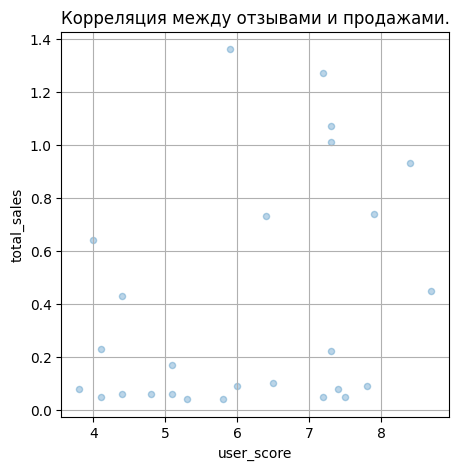

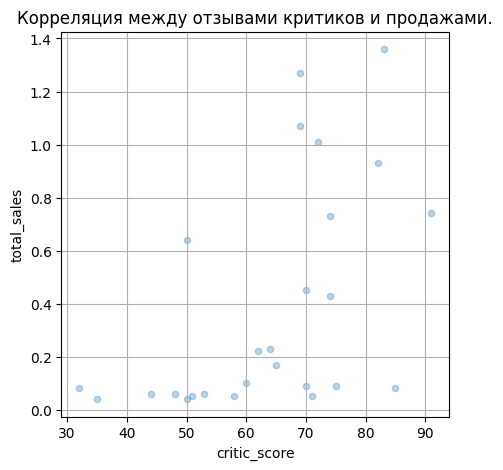

C:\Users\Alim\AppData\Local\Temp\ipykernel_8652\4172242928.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  x360.corr()


,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales
year_of_release,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
na_sales,NaN,1.000000,0.868295,0.607244,0.992850,0.539778,0.333766,0.985611
eu_sales,NaN,0.868295,1.000000,0.304520,0.906479,0.443965,0.313098,0.939489
jp_sales,NaN,0.607244,0.304520,1.000000,0.564631,0.435430,0.087589,0.527556
other_sales,NaN,0.992850,0.906479,0.564631,1.000000,0.544409,0.342506,0.994262
critic_score,NaN,0.539778,0.443965,0.435430,0.544409,1.000000,0.625309,0.525723
user_score,NaN,0.333766,0.313098,0.087589,0.342506,0.625309,1.000000,0.336514
total_sales,NaN,0.985611,0.939489,0.527556,0.994262,0.525723,0.336514,1.000000


In [38]:
x360 = actual_period[(actual_period['platform'] == 'X360') & (actual_period['critic_score']>0) & (actual_period['user_score']>0)].copy()
x360.plot(x='user_score', y='total_sales', kind='scatter', alpha=0.3, figsize=(5,5), grid=True, title='Корреляция между отзывами и продажами.')
plt.show()
x360.plot(x='critic_score', y='total_sales', kind='scatter', alpha=0.3, figsize=(5,5), grid=True, title='Корреляция между отзывами критиков и продажами.')
plt.show()
x360.corr()

Замена пропусков на *-1* и *tbd* на -2 позволила нам увидеть их на графиках и не учитывать в оценке корреляции.

Полученные графики и матрица корреляции на основе нескольких популярных платформ показывают, что хорошая оценка пользователей очень слабо коррелирует с высоким уровнем продаж игры. В то же время видна корреляция между продажами и оценкой критиков. То есть можно сделать вывод, что критики оценивают более объективно.

#### Посмотрим на общее распределение игр по жанрам.

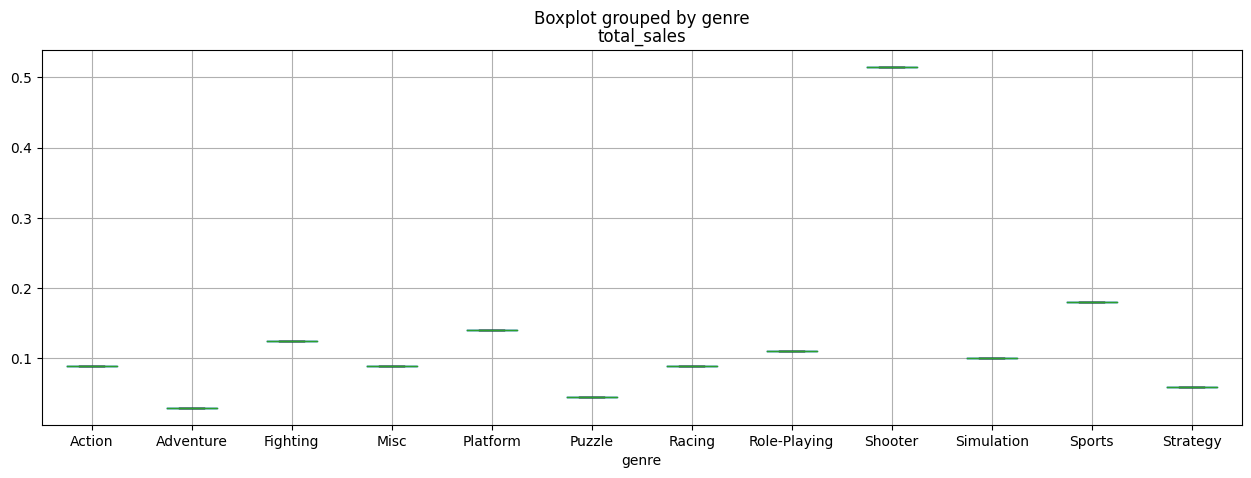

In [39]:
actual_period.pivot_table(index='genre', values='total_sales', aggfunc='median').boxplot(column='total_sales', by='genre', figsize=(15,5))
plt.show()

Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

Наибольшую прибыль приносят игры в жанрах: **Platform**, **Shooter** и **Sports**. С существенным отрывом лидируют шутеры, на их продажи имеет смысл сделать акцент в 2017 году.

### Составим портрет пользователя каждого региона

**Определим для пользователя каждого региона (NA, EU, JP):**

#### Самые популярные платформы (ТОП-5). Опишите различия в долях продаж.

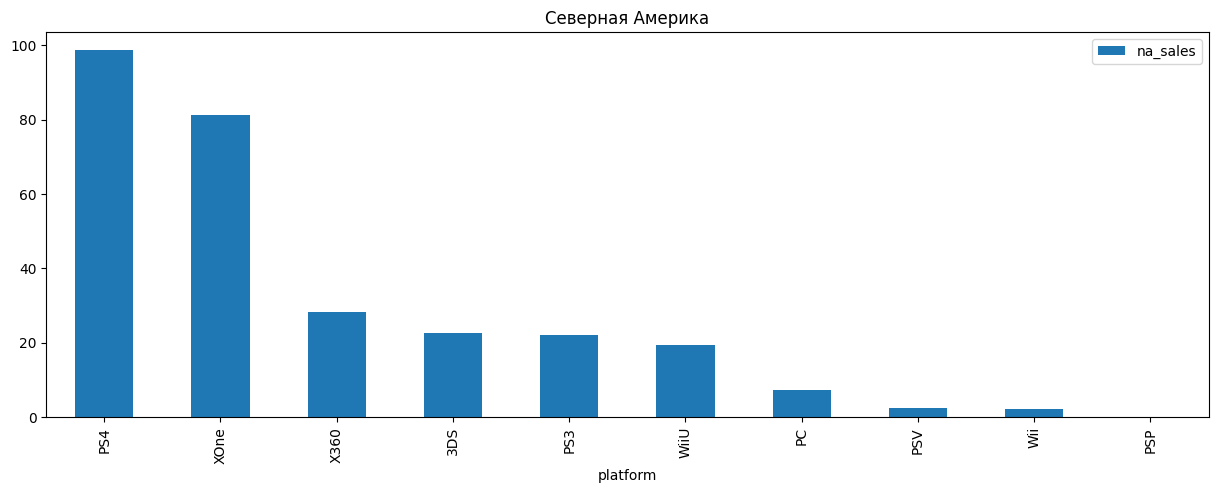

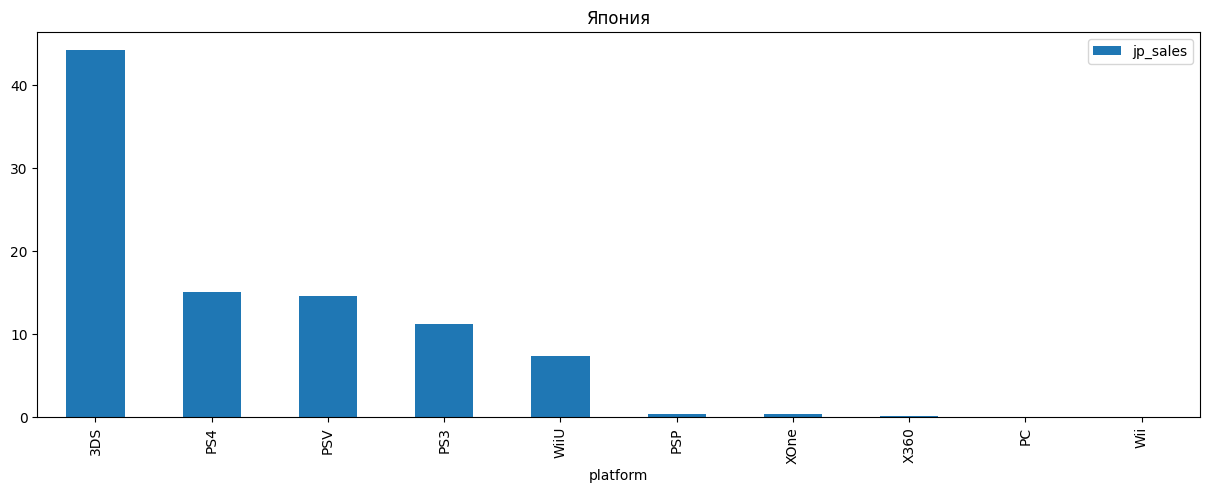

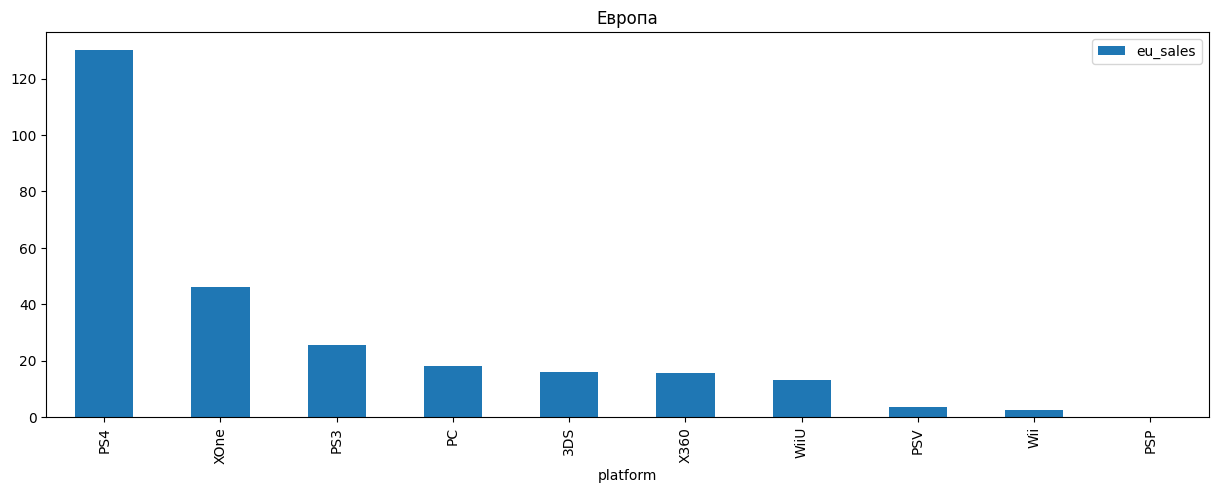

In [40]:
actual_period.pivot_table(index='platform', values='na_sales', aggfunc='sum').sort_values(ascending=False, by='na_sales').plot(kind='bar', figsize=(15,5), title='Северная Америка');
actual_period.pivot_table(index='platform', values='jp_sales', aggfunc='sum').sort_values(ascending=False, by='jp_sales').plot(kind='bar', figsize=(15,5), title='Япония');
actual_period.pivot_table(index = 'platform', values = 'eu_sales', aggfunc = 'sum').sort_values(ascending=False, by = 'eu_sales').plot(kind = 'bar', figsize=(15,5), title='Европа');

Полученные  графики показывают, что в Северной Америке самая популярная игровая консоль - **X360**, в Японии - **3DS**, а в Европе - **PS3**. При этом консоли **PS3** и **PS4** входят в ТОП-3 всех регионов, наряду со вхождением в ТОП-3 консоли **PSP** в Японии. Из этого можно сделать вывод, что компания **Sony** является устойчивым лидером продаж на игровом рынке. Также можно сделать вывод, что в ТОП-5 практически везде входят платформы: **PS-3**, **PS-4**, **3DS**, **X360** - крупные игроки, выпускающие эксклюзивные игры. Можно также отметить, что жители Европы также предпочитают играть на **PC**, жители Японии предпочитают консоли своей страны от компании Sony, а жители Северной Америки X360 и XOne - продукт американской компании Microsoft, вероятно это значит, что США и Япония лучше ориентируются на рынке своих стран и в Европе отсутствует игрок, который может себя им противопоставить.

#### Самые популярные жанры (топ-5). Поясните разницу.

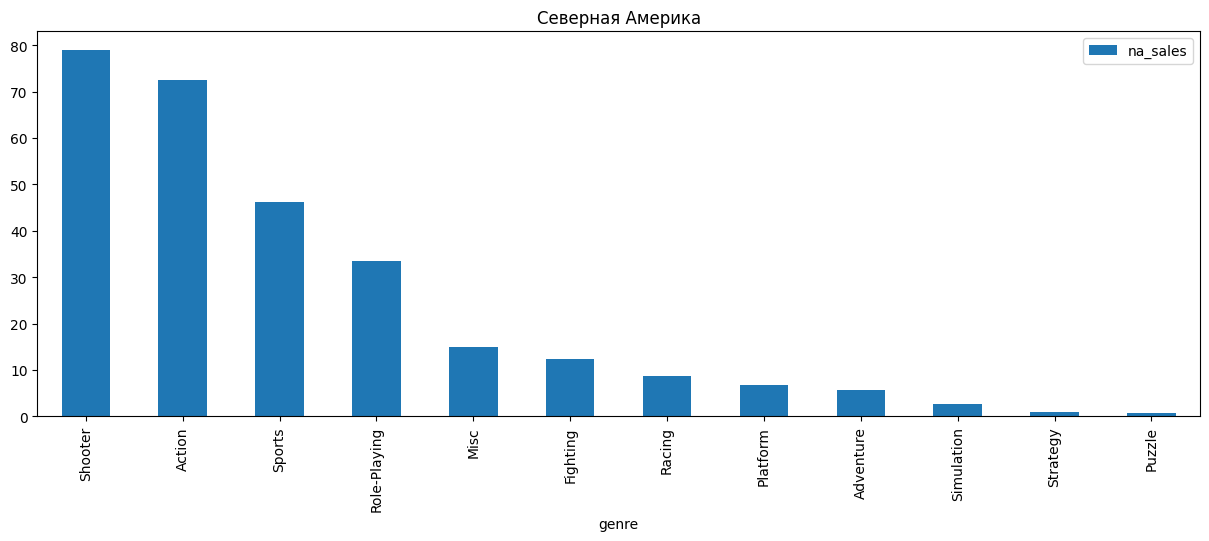

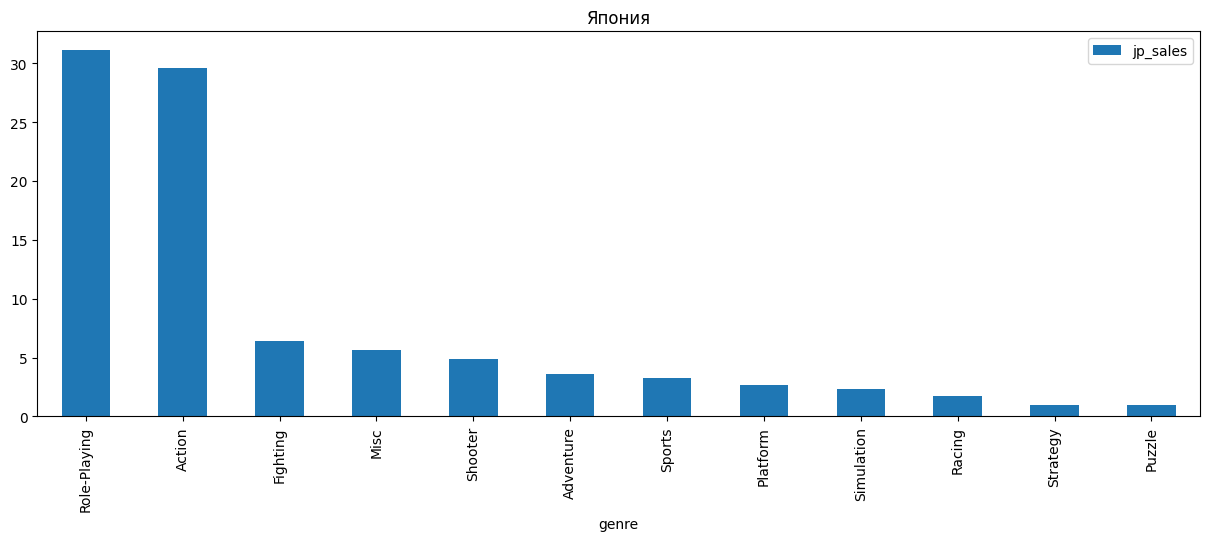

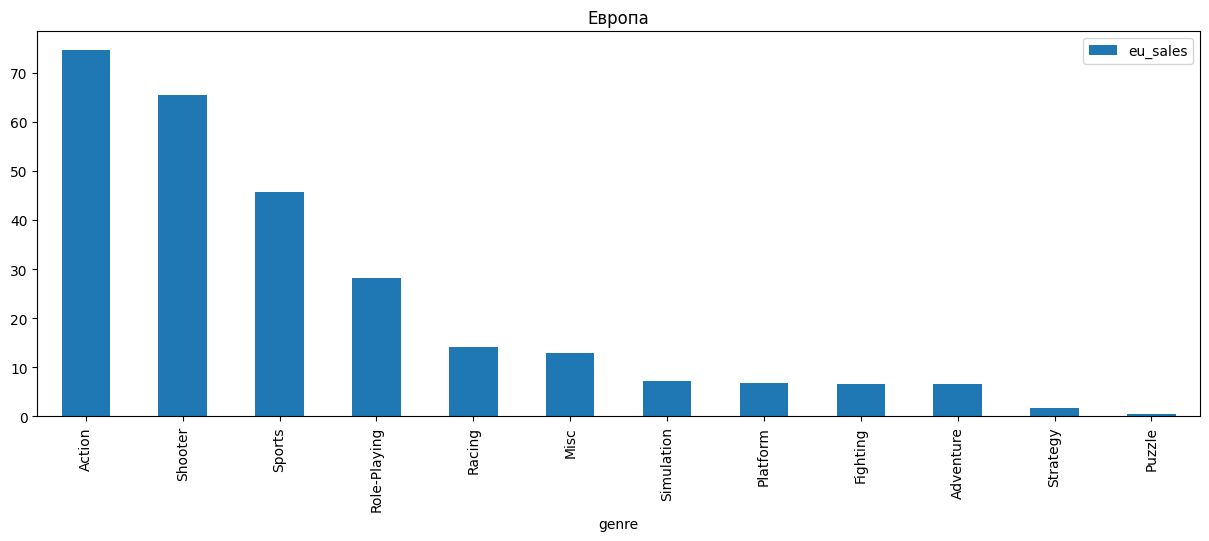

In [41]:
actual_period.pivot_table(index='genre', values='na_sales', aggfunc='sum').sort_values(ascending=False, by='na_sales').plot(kind='bar', figsize=(15,5), title='Северная Америка');
actual_period.pivot_table(index='genre', values='jp_sales', aggfunc='sum').sort_values(ascending=False, by='jp_sales').plot(kind='bar', figsize=(15,5), title='Япония');
actual_period.pivot_table(index = 'genre', values = 'eu_sales', aggfunc = 'sum').sort_values(ascending=False, by = 'eu_sales').plot(kind = 'bar', figsize=(15,5), title='Европа');


В ТОП-5 жанров во всех трёх регионах входят жанры **Action** и **Role-Playing**, в двух из трёх присутствуют жанры **Shooter**, **Sports**, **Racing**. Предпочтения японцев также отличает любовь к жанрам **Misc**, **Fighting** и **Platform**.

#### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [42]:
esrb_rating = actual_period.pivot_table(index = 'rating', values = ['na_sales', 'jp_sales', 'eu_sales'], aggfunc = 'sum')
esrb_rating

,eu_sales,jp_sales,na_sales
rating,,,
E,58.06,8.94,50.74
E10+,26.16,4.46,33.23
M,93.44,8.01,96.42
T,34.07,14.78,38.95
Отсутствует,58.95,56.90,64.72


Предпочтения пользователей из разных регионов действительно зависят от возрастного рейтинга игры. Нужно учитывать региональные особенности и выводить на рынок игры, с рейтингом, который больше предпочитают пользователи.

### Проверим гипотезы

Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

In [43]:
XOne = actual_period[(actual_period['platform'] == 'XOne') &  (actual_period['user_score'] > 0)]['user_score']
PC = actual_period[(actual_period['platform'] == 'PC') &  (actual_period['user_score'] > 0)]['user_score']
print('Средний user_score платформы Xbox One:', XOne.mean())
print('Средний user_score платформы PC', PC.mean())

Средний user_score платформы Xbox One: 6.594545454545456
Средний user_score платформы PC 6.298360655737705


In [44]:
alpha = .05

results = st.ttest_ind(XOne, PC, equal_var=False)

print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Гипотеза не подтвердилась")
else:
    print("Гипотеза подтвердилась")

p-значение: 0.11601398086668835
Гипотеза подтвердилась


Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

In [45]:
action = actual_period[(actual_period['genre'] == 'Action') &  (actual_period['user_score'] > 0)]['user_score']
sports = actual_period[(actual_period['genre'] == 'Sports') &  (actual_period['user_score'] > 0)]['user_score']
print('Средний user_score жанра Action:', action.mean())
print('Средний user_score жанра Sports', sports.mean())

Средний user_score жанра Action: 6.760606060606061
Средний user_score жанра Sports 5.2251968503937


In [46]:
alpha = .05

results = st.ttest_ind(action, sports, equal_var=False)

print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Гипотеза не подтвердилась")
else:
    print("Гипотеза подтвердилась")

p-значение: 1.1825550382644557e-14
Гипотеза не подтвердилась


По итогам этого этапа исследования мы получили портрет пользователя в трёх регионах мира и выявили различия в их жанровых предпочтениях и популярности игровых платформ. Стоит обратить внимание, что шутеры отлично продаются во всём мире. Важный вывод состоит в том, что игры с разным возрастным рейтингом по-разному продаются в мире. Проверка гипотез показала, что у нас есть основания полагать, что средние пользовательские рейтинги платформ Xbox One и PC и рейтинги жанров Action, Sports одинаковые.

# Вывод

Цель исследования была в выявлении определяющих успешность игры закономерностей. По его итогам можно сделать вывод, что есть региональные особенности на рынке игр, но в то же время стоит сделать упор на продажу продуктов компании SONY, платформы которой популярны везде. Можно также обратить внимание на предпочтения пользователей разных регионов в зависимости от возрастного рейтинга, этот показатель является очень важным. Если учитывать жанровые предпочтения, то лучше всего будут продаваться игры жанров Shooter, на их продажи стоит сделать акцент в первую очередь.

Для успеха продаж в 2017 году нужно:

- продавать больше игр жанра Shooter по всему миру
- акцентировать внимание на продажи игрф для следующих платформ: 'DS', 'Wii', 'PS3', 'X360', 'PS2'
- В разных регионах продавать больше игр с наиболее популярным возрастным рейтингом. В Северной Америке и Европе - M, в Японии E.